## Import of Libraries

In [43]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import datetime
import talib
import backtesting as bt
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ttest_1samp
from scipy import stats
import scipy.stats as stats
warnings.filterwarnings("ignore")
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from backtesting import Backtest, Strategy
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib

## Stock Data / Pre Processing

Load File with stock data, check for missing data 

In [2]:
#import stock data from excel file
# Define the filename for the Excel file
input_file = 'dow_data.xlsx'

# Read the Excel file and store the data in a dictionary
df_all = pd.read_excel(input_file, sheet_name=None, parse_dates=['Date'], index_col=0)


In [3]:
# Iterate through df_all and find the first date of each df
first_dates = {}
for sheet_name, df in df_all.items():
    first_date = df.index.min()
    first_dates[sheet_name] = first_date

# Print the first dates of each df
for sheet_name, first_date in first_dates.items():
    print(f"First date of {sheet_name}: {first_date}")


First date of MMM: 2001-12-31 00:00:00
First date of AXP: 2001-12-31 00:00:00
First date of AMGN: 2001-12-31 00:00:00
First date of AAPL: 2001-12-31 00:00:00
First date of BA: 2001-12-31 00:00:00
First date of CAT: 2001-12-31 00:00:00
First date of CVX: 2001-12-31 00:00:00
First date of CSCO: 2001-12-31 00:00:00
First date of KO: 2001-12-31 00:00:00
First date of DIS: 2001-12-31 00:00:00
First date of DOW: 2019-03-20 00:00:00
First date of GS: 2001-12-31 00:00:00
First date of HD: 2001-12-31 00:00:00
First date of HON: 2001-12-31 00:00:00
First date of IBM: 2001-12-31 00:00:00
First date of INTC: 2001-12-31 00:00:00
First date of JNJ: 2001-12-31 00:00:00
First date of JPM: 2001-12-31 00:00:00
First date of MCD: 2001-12-31 00:00:00
First date of MRK: 2001-12-31 00:00:00
First date of MSFT: 2001-12-31 00:00:00
First date of NKE: 2001-12-31 00:00:00
First date of PG: 2001-12-31 00:00:00
First date of CRM: 2004-06-23 00:00:00
First date of TRV: 2001-12-31 00:00:00
First date of UNH: 2001-1

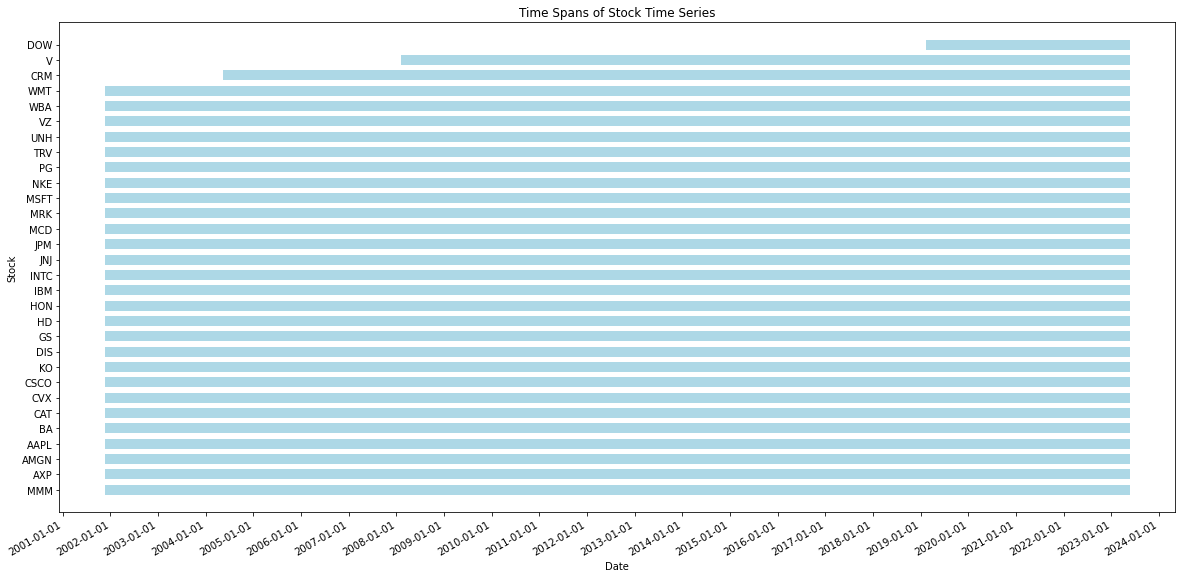

In [4]:

# Extract start and end dates for each stock in df_all
dates = {stock: (df.index.min(), df.index.max()) for stock, df in df_all.items()}

# Separate out the stock names and start/end dates
stock_names, date_ranges = zip(*dates.items())
start_dates, end_dates = zip(*date_ranges)

# Sort stocks by start date
sorted_pairs = sorted(zip(stock_names, start_dates, end_dates), key=lambda x: x[1])
sorted_stock_names, sorted_start_dates, sorted_end_dates = zip(*sorted_pairs)

# Create timeline plot
plt.figure(figsize=(20,10))  # Increase figure size
for i, (stock, start_date, end_date) in enumerate(zip(sorted_stock_names, sorted_start_dates, sorted_end_dates)):
    plt.plot([start_date, end_date], [i, i], color='lightblue', linewidth=10)  # Plot as line
    plt.scatter([start_date, end_date], [i, i], color='red', s=50)  # Highlight start and end with a dot

plt.yticks(range(len(sorted_stock_names)), sorted_stock_names)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format x-axis display
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to be every year
plt.gcf().autofmt_xdate()  # Rotation
plt.title('Time Spans of Stock Time Series')
plt.xlabel('Date')
plt.ylabel('Stock')
plt.grid(False)
plt.show()


In [5]:
#delete three stocks with incomplete data

to_delete = ['DOW', 'CRM', 'V']

for sheet_name in to_delete:
    del df_all[sheet_name]

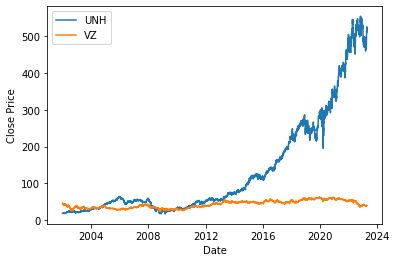

In [6]:
#find  stocks with biggest difference in stock price at the the last date of the time series
stock1 = max(df_all, key=lambda k: df_all[k]['Close'].iloc[-1] - df_all[k]['Close'].iloc[0])
stock2 = min(df_all, key=lambda k: df_all[k]['Close'].iloc[-1] - df_all[k]['Close'].iloc[0])

plt.plot(df_all[stock1]['Close'], label=stock1)
plt.plot(df_all[stock2]['Close'], label=stock2)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.show()


## Functions Definitions

Definition of several functions, will later be used to calculate Technical Indicators, Generate Signals, Train Models etc.

In [7]:
# define function to calculate technical indicators

def calculate_technical_indicators2(df):
    # Calculate MACD
    macd, macd_signal, macd_hist = talib.MACD(df['Close'])

    # Calculate EMA
    ema_5 = talib.EMA(df['Close'], timeperiod=5)
    ema_20 = talib.EMA(df['Close'], timeperiod=20)

    # Calculate Bollinger Bands
    upper, middle, lower = talib.BBANDS(df['Close'], timeperiod = 20)

    # Calculate RSI
    rsi = talib.RSI(df['Close'])

    # Calculate Stochastic Oscillator
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period = 14)

    # Calculate Fibonacci retracements for last 20 periods
    high = df['High'].rolling(window=20).max()
    low = df['Low'].rolling(window=20).min()
    diff = high - low
    retracement1 = high - 0.236 * diff
    retracement2 = high - 0.382 * diff
    retracement3 = high - 0.618 * diff

    # Update the dataframe with the calculated indicator values
    df['MACD'] = macd
    df['MACD_Signal'] = macd_signal
    df['MACD_Hist'] = macd_hist
    df['EMA_5'] = ema_5
    df['EMA_20'] = ema_20
    df['Upper_BB'] = upper
    df['Middle_BB'] = middle
    df['Lower_BB'] = lower
    df['RSI'] = rsi
    df['SlowK'] = slowk
    df['SlowD'] = slowd
    df['Fibonacci_0.236'] = retracement1
    df['Fibonacci_0.382'] = retracement2
    df['Fibonacci_0.618'] = retracement3

    return df


In [8]:
#define function to create target variables etc.

def prepare_data(df, shifts):
    # Create a copy of the original DataFrame
    df_copy = df.copy()

    # Loop through each shift in shifts
    for shift in shifts:
        # Calculate the target for each shift
        target = df['Close'].shift(-shift)

        # Assign a name to the target Series
        target.name = f'Target_{shift}'

        # Add the target to the dataframe
        df_copy[target.name] = target

    # Remove rows with NaN values in target columns
    df_cleaned = df_copy.dropna(subset=[f'Target_{shift}' for shift in shifts])

    # Align the lengths of target and index
    for shift in shifts:
        target = df_cleaned[f'Target_{shift}'].shift(shift).dropna()
        df_cleaned = df_cleaned.iloc[:len(target), :]

        # Update the 'Target' column with the shifted values
        df_cleaned[f'Target_{shift}'] = target.values

    return df_cleaned

In [10]:
### model to train and optimize using grid search. Calling the function takes more than 1hr, depending on pc performance.
##saved models can be  loaded (.pkl File)

def train_model(stock, shift, df, target_name):
    X = df[['MACD', 'MACD_Signal', 'MACD_Hist', 'EMA_5', 'EMA_20', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'RSI', 'SlowK', 'SlowD', 'Fibonacci_0.236', 'Fibonacci_0.382', 'Fibonacci_0.618']]
    y = df[target_name]

    # Standardize the inputs
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Fit the standard model
    standard_model = SVR()
    standard_model.fit(X, y)

    # Make predictions on the training set using the standard model
    y_pred_standard = standard_model.predict(X)

    # Calculate MAPE for the standard model
    mape_standard = mean_absolute_percentage_error(y, y_pred_standard)

    # Calculate RMSE for the standard model
    rmse_standard = np.sqrt(mean_squared_error(y, y_pred_standard))

    # Calculate the model score for the standard model
    score_standard = standard_model.score(X, y)

    # Create a dataframe to store the scores
    scores_df = pd.DataFrame({'Stock': [f'{stock}_{shift}'], 'Model': ['Standard Model'], 'MAPE': [mape_standard], 'RMSE': [rmse_standard], 'Model Score': [score_standard]})

 
    # Define the SVR model
    svr = SVR()

    # Define the parameter grid for hyperparameter optimization
    param_grid = {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.1, 0.01],
        'gamma': ['scale', 'auto', 0.1, 1, 10]
    }

    # Use TimeSeriesSplit for time series cross-validation with 3 splits
    tscv = TimeSeriesSplit(n_splits=3)

    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Fit the best model on the entire dataset
    best_model.fit(X, y)

    # Make predictions on the training set using the best model
    y_pred_best = best_model.predict(X)

    # Calculate MAPE for the best model
    mape_best = mean_absolute_percentage_error(y, y_pred_best)

    # Calculate RMSE for the best model
    rmse_best = np.sqrt(mean_squared_error(y, y_pred_best))

    # Calculate the model score for the best model
    score_best = best_model.score(X, y)

    # Add the scores of the best model to the dataframe
    scores_df = scores_df.append({'Stock': f'{stock}_{shift}', 'Model': 'Best Model (Grid Search)', 'MAPE': mape_best, 'RMSE': rmse_best, 'Model Score': score_best}, ignore_index=True)

    # Print the evaluation metrics
    print("Evaluation Metrics:")
    print(scores_df)

    return best_model, scores_df



In [11]:
## function to make predictions using trained models

def make_predictions(df, model, target_name):
    # Extract the features from the dataframe
    X = df[['MACD', 'MACD_Signal', 'MACD_Hist', 'EMA_5', 'EMA_20', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'RSI', 'SlowK', 'SlowD', 'Fibonacci_0.236', 'Fibonacci_0.382', 'Fibonacci_0.618']]

    # Initialize the scaler
    scaler = StandardScaler()

    # Standardize the features
    X_standardized = scaler.fit_transform(X)

    # Use the trained model to make predictions on the standardized features
    predictions = model.predict(X_standardized)

    # Construct the prediction column name
    prediction_column_name = f'{target_name}'

    # Add the predictions as a new column to the dataframe
    df[prediction_column_name] = predictions

    # Return the updated dataframe with predictions
    return df

In [12]:
### loading models that have been trained previously

models = joblib.load('svr_model3.pkl')
models.keys()

dict_keys([('MMM', 5), ('MMM', 20), ('MMM', 90), ('AXP', 5), ('AXP', 20), ('AXP', 90), ('AMGN', 5), ('AMGN', 20), ('AMGN', 90), ('AAPL', 5), ('AAPL', 20), ('AAPL', 90), ('BA', 5), ('BA', 20), ('BA', 90), ('CAT', 5), ('CAT', 20), ('CAT', 90), ('CVX', 5), ('CVX', 20), ('CVX', 90), ('CSCO', 5), ('CSCO', 20), ('CSCO', 90), ('KO', 5), ('KO', 20), ('KO', 90), ('DIS', 5), ('DIS', 20), ('DIS', 90), ('GS', 5), ('GS', 20), ('GS', 90), ('HD', 5), ('HD', 20), ('HD', 90), ('HON', 5), ('HON', 20), ('HON', 90), ('IBM', 5), ('IBM', 20), ('IBM', 90), ('INTC', 5), ('INTC', 20), ('INTC', 90), ('JNJ', 5), ('JNJ', 20), ('JNJ', 90), ('JPM', 5), ('JPM', 20), ('JPM', 90), ('MCD', 5), ('MCD', 20), ('MCD', 90), ('MRK', 5), ('MRK', 20), ('MRK', 90), ('MSFT', 5), ('MSFT', 20), ('MSFT', 90), ('NKE', 5), ('NKE', 20), ('NKE', 90), ('PG', 5), ('PG', 20), ('PG', 90), ('TRV', 5), ('TRV', 20), ('TRV', 90), ('UNH', 5), ('UNH', 20), ('UNH', 90), ('VZ', 5), ('VZ', 20), ('VZ', 90), ('WBA', 5), ('WBA', 20), ('WBA', 90), ('WM

In [13]:
#generate trading signals

def generate_signals(df, shift):
    # Calculate the Average True Range for the given shift
    df['ATR'] = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=shift)
    
    # Compare the predicted prices with the current prices for the given shift
    current_prices = df['Close']
    predicted_prices = df[f'pred_{shift}']
    signal_column = ['Hold'] * len(df)  # Initialize the signal column with 'Hold'
    
    for i in range(shift, len(df)):  # Start from 'shift' to consider ATR
        atr = df['ATR'][i]
        
        if predicted_prices[i] >= current_prices[i] + 2 * atr:  # 2*ATR above current price
            signal_column[i] = 'Buy'
        elif predicted_prices[i] <= current_prices[i] - 2 * atr:  # 2*ATR below current price
            signal_column[i] = 'Sell'

    # Update the dataframe with the signal column for the given shift
    signal_column_name = f'Signal_{shift}'
    df[signal_column_name] = signal_column

    return df


In [14]:
##simple trading strategy for single stocks

class myStrat(Strategy):
    take_profit = 0  # in points
    stop_loss = 0    # in points
    
    def init(self):
        self.entry_price = None

    def next(self):
        price = self.data.Close[-1]

        if not self.position:
            if self.data.Signal[-1] == 'Buy':
                self.buy()
                self.entry_price = price
                
        elif self.data.Signal[-1] == 'Sell':
            self.position.close()
            self.entry_price = None
            
        elif self.entry_price is not None:  # Check if there is an entry price
            take_profit_price = self.entry_price + self.take_profit
            stop_loss_price = self.entry_price - self.stop_loss

            if price >= take_profit_price or price <= stop_loss_price:
                self.position.close()
                self.entry_price = None


In [15]:
### Calculate Technical Indicators on all stocks


for stock, df in df_all.items():
    df_all[stock] = calculate_technical_indicators2(df)
    df_all[stock].dropna(inplace=True)

In [16]:
shifts = [5, 20, 90]  # Define shifts

#preparte data function

for stock, df in df_all.items():
    df_all[stock] = prepare_data(df, shifts)
    df_all[stock] = pd.DataFrame(df_all[stock])

In [17]:
### do not run - models are saved in .pkl file.

%%time
'''
models = {}
scores_all = pd.DataFrame(columns=['Stock', 'Model', 'MAPE', 'RMSE', 'Model Score'])

for stock, df in df_all.items():
    for shift in shifts:
        target_name = f'Target_{shift}'
        model, scores = train_model(stock, shift, df, target_name)
        models[(stock, shift)] = model
        scores_all = scores_all.append(scores, ignore_index=True)
'''


UsageError: Line magic function `%%time` not found.


In [18]:
### do not run. code is to save models. 
'''
joblib.dump(models, 'svr_model3.pkl')

'''

"\njoblib.dump(models, 'svr_model3.pkl')\n\n"

In [19]:
# load previously trained models

models = joblib.load('svr_model3.pkl')

In [20]:
#save best model params to dataframe

models_dict = models

# Convert dictionary to a list of dictionaries
models_list = []
for key, value in models_dict.items():
    model_dict = {}
    model_dict['Model'] = key[0]
    model_dict['Shift'] = key[1]
    model_dict['C'] = value.C
    model_dict['Epsilon'] = value.epsilon if 'epsilon' in value.get_params() else None
    model_dict['Gamma'] = value.gamma
    models_list.append(model_dict)

# Create DataFrame
df_models = pd.DataFrame(models_list)
df_models.to_excel('Models_Params.xlsx')

In [23]:
# load model scores
excel_file_path = 'model_scores.xlsx'

scores_all = pd.read_excel('model_scores.xlsx')


scores_all.head(20)

,Stock,Model,MAPE,RMSE,Model Score
0,MMM_5,Standard Model,0.032051,6.331885,0.984580
1,MMM_5,Best Model (Grid Search),0.019159,3.311872,0.995781
2,MMM_20,Standard Model,0.049107,8.400981,0.972749
3,MMM_20,Best Model (Grid Search),0.039519,6.751344,0.982400
4,MMM_90,Standard Model,0.085518,13.916123,0.923954
5,MMM_90,Best Model (Grid Search),0.085530,13.915817,0.923957
6,AXP_5,Standard Model,0.052227,7.404556,0.958792
7,AXP_5,Best Model (Grid Search),0.024931,2.459558,0.995453
8,AXP_20,Standard Model,0.076122,8.472577,0.946479
9,AXP_20,Best Model (Grid Search),0.051684,5.242178,0.979511


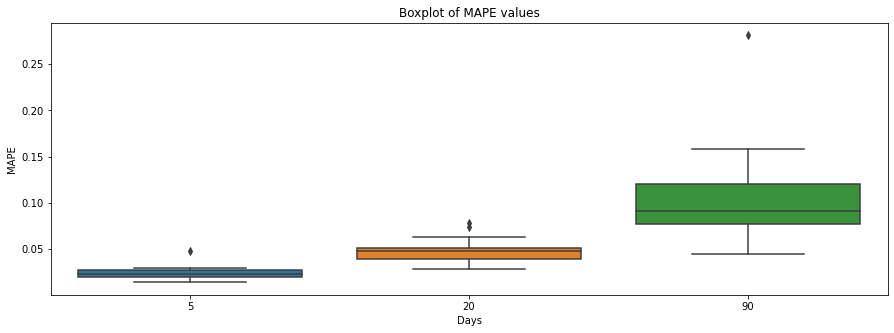

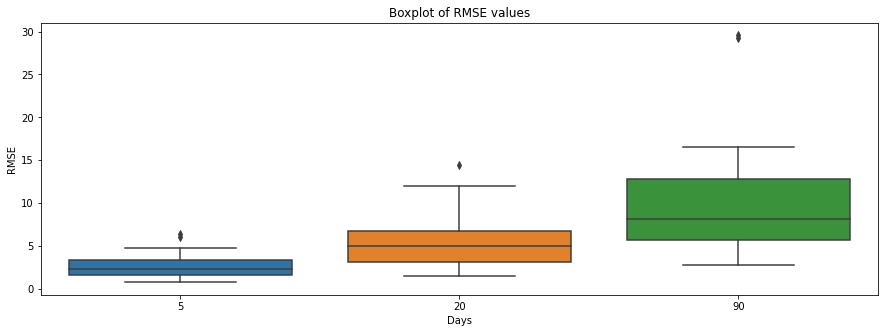

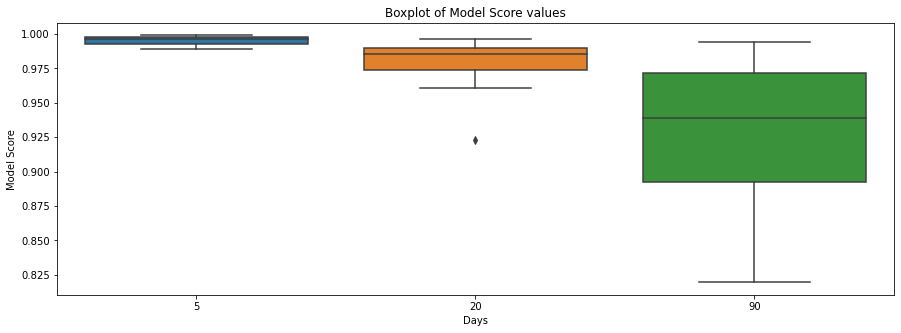

In [24]:
# Filter the data for only "Best Model (Grid Search)"
df_best = scores_all[scores_all['Model'] == 'Best Model (Grid Search)']

# Split the Stock column into Stock and Days columns
df_best[['Stock','Days']] = df_best['Stock'].str.split('_',expand=True)

# Creating boxplot for MAPE values
plt.figure(figsize=(15, 5))
sns.boxplot(x='Days', y='MAPE', data=df_best)
plt.title('Boxplot of MAPE values')
plt.show()

# Creating boxplot for RMSE values
plt.figure(figsize=(15, 5))
sns.boxplot(x='Days', y='RMSE', data=df_best)
plt.title('Boxplot of RMSE values')
plt.show()

# Creating boxplot for Model Score values
plt.figure(figsize=(15, 5))
sns.boxplot(x='Days', y='Model Score', data=df_best)
plt.title('Boxplot of Model Score values')
plt.show()

In [27]:
##make predictions for all stock time series

for stock, df in df_all.items():
    for shift in shifts:
        target_name = f'pred_{shift}'
        model = models[(stock, shift)]
        df_all[stock] = make_predictions(df_all[stock], model, target_name)



In [28]:
#generate signals

for stock, df in df_all.items():
    for shift in shifts:
        df_all[stock] = generate_signals(df_all[stock], shift)

In [29]:
df_all['MMM']

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_Signal,MACD_Hist,EMA_5,...,Target_5,Target_20,Target_90,ATR,pred_5,pred_20,pred_90,Signal_5,Signal_20,Signal_90
Date,,,,,,,,,,,,,,,,,,,,,
2002-02-19,57.724998,57.869999,56.900002,56.994999,32.289169,3964400,0.282599,-0.252450,0.535049,57.311583,...,59.650002,60.849998,62.584999,NaN,58.485589,60.138260,70.076271,Hold,Hold,Hold
2002-02-20,57.049999,58.849998,56.775002,58.549999,33.351536,3624000,0.417910,-0.118378,0.536288,57.724389,...,59.500000,59.950001,61.500000,NaN,58.648847,59.682920,67.138030,Hold,Hold,Hold
2002-02-21,58.625000,59.250000,58.000000,58.000000,33.038242,4535000,0.475286,0.000355,0.474932,57.816259,...,58.965000,59.150002,63.700001,NaN,58.715171,59.254415,66.508180,Hold,Hold,Hold
2002-02-22,58.005001,59.665001,58.000000,59.500000,33.892677,4747200,0.634481,0.127180,0.507301,58.377506,...,60.160000,58.195000,62.884998,NaN,59.190726,60.008391,67.998852,Hold,Hold,Hold
2002-02-25,59.500000,60.400002,59.090000,60.224998,34.305656,5658200,0.809810,0.263706,0.546104,58.993337,...,61.505001,57.849998,63.049999,NaN,59.896837,60.754183,68.964984,Hold,Hold,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-14,136.679993,138.350006,134.399994,135.250000,130.597488,2675200,-2.548240,-1.291103,-1.257137,138.932683,...,130.399994,128.309998,116.809998,3.441601,138.886539,139.498091,149.435966,Hold,Hold,Buy
2022-06-15,135.759995,136.679993,133.059998,134.330002,129.709152,3271100,-3.008418,-1.634566,-1.373852,137.398456,...,130.149994,130.130005,118.379997,3.443583,137.249398,137.856166,147.938710,Hold,Hold,Buy
2022-06-16,132.550003,132.550003,130.330002,130.940002,126.435768,3728200,-3.605100,-2.028673,-1.576428,135.245638,...,134.330002,128.910004,118.500000,3.449766,134.340111,133.992093,145.893392,Hold,Hold,Buy


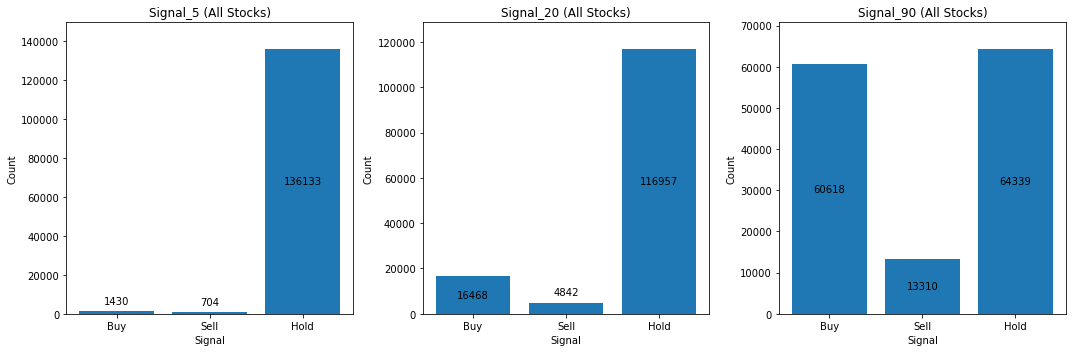

In [30]:
# Create a list of signal column names
signal_columns = [f'Signal_{shift}' for shift in shifts]

# Specify the order of the bars
order = ['Buy', 'Sell', 'Hold']

# Initialize a large figure
fig, axs = plt.subplots(1, len(signal_columns), figsize=(15, 5))

# Loop over the signal columns
for i, column in enumerate(signal_columns):
    combined_signal_counts = pd.Series(dtype=int)  # Initialize an empty series

    # Loop over all dataframes in the dictionary
    for stock, df in df_all.items():
        # Count the occurrences of each value in the signal column and combine
        signal_counts = df[column].value_counts()
        combined_signal_counts = combined_signal_counts.add(signal_counts, fill_value=0)

    # Convert the counts to integer
    combined_signal_counts = combined_signal_counts.astype(int)

    # Ensure the bars are in the specified order
    combined_signal_counts = combined_signal_counts.reindex(order, fill_value=0)

    # Visualize the combined counts using a bar plot
    axs[i].bar(combined_signal_counts.index, combined_signal_counts.values)
    axs[i].set_xlabel('Signal')
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'{column} (All Stocks)')

    # Adjust the y-axis limits dynamically based on the maximum count
    max_count = combined_signal_counts.max()
    axs[i].set_ylim(0, max_count + max_count * 0.1)  # Add 10% padding to the upper limit

    # Modify y-axis labels to show absolute values
    for j, count in enumerate(combined_signal_counts.values):
        # Position the text inside the bars to prevent overlapping
        if count < max_count * 0.05:  # Adjust the threshold as needed
            axs[i].text(j, count + max_count * 0.02, str(abs(count)), ha='center', va='bottom')
        else:
            axs[i].text(j, count / 2, str(abs(count)), ha='center', va='center')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### backtesting of single stock strategies, buy / sell - not used in thesis

In [31]:
results_df = pd.DataFrame(columns=['Stock', 'Signal', 'Strategy Return [%]', 'Buy and Hold Return [%]'])
signal_columns = ['Signal_5', 'Signal_20', 'Signal_90']

for stock, df in df_all.items():
    for signal in signal_columns:
        df_temp = df.rename(columns={signal: 'Signal'})
        bt = Backtest(df_temp[-1000:], myStrat)
        stats = bt.run()
        
        # Calculate returns for both strategies
        my_return = stats['Return [%]']
        buy_and_hold_return = stats['Buy & Hold Return [%]']
        
        # Add the results to the DataFrame
        results_df = results_df.append({
            'Stock': stock,
            'Signal': signal,
            'Strategy Return [%]': my_return,
            'Buy and Hold Return [%]': buy_and_hold_return
        }, ignore_index=True)
        
        # Analyze the performance and evaluate the strategy
        print(f"Performance for {stock} with {signal}:")
        print(stats)


Performance for MMM with Signal_5:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                         0.4
Equity Final [$]                 10167.759735
Equity Peak [$]                  10167.759735
Return [%]                           1.677597
Buy & Hold Return [%]              -33.505528
Return (Ann.) [%]                    0.420128
Volatility (Ann.) [%]                0.630904
Sharpe Ratio                         0.665914
Sortino Ratio                        4.410132
Calmar Ratio                         2.214976
Max. Drawdown [%]                   -0.189676
Avg. Drawdown [%]                   -0.189676
Max. Drawdown Duration        4 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       1.239434
Worst Trade [%]                      0.448833

Performance for AMGN with Signal_90:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        40.4
Equity Final [$]                  12823.52739
Equity Peak [$]                  12962.578232
Return [%]                          28.235274
Buy & Hold Return [%]                28.66858
Return (Ann.) [%]                    6.467705
Volatility (Ann.) [%]               14.888667
Sharpe Ratio                         0.434405
Sortino Ratio                        0.699378
Calmar Ratio                         0.398644
Max. Drawdown [%]                  -16.224269
Avg. Drawdown [%]                    -3.49193
Max. Drawdown Duration      274 days 00:00:00
Avg. Drawdown Duration       57 days 00:00:00
# Trades                                  202
Win Rate [%]                        52.970297
Best Trade [%]                       5.257779
Worst Trade [%]                      -7.849

Performance for CAT with Signal_20:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        14.0
Equity Final [$]                 12840.637482
Equity Peak [$]                  14161.089233
Return [%]                          28.406375
Buy & Hold Return [%]               44.082475
Return (Ann.) [%]                    6.503485
Volatility (Ann.) [%]               11.431283
Sharpe Ratio                          0.56892
Sortino Ratio                        1.046433
Calmar Ratio                         0.460473
Max. Drawdown [%]                  -14.123498
Avg. Drawdown [%]                   -3.556141
Max. Drawdown Duration      448 days 00:00:00
Avg. Drawdown Duration       76 days 00:00:00
# Trades                                   70
Win Rate [%]                        52.857143
Best Trade [%]                       7.876407
Worst Trade [%]                     -5.05424

Performance for CSCO with Signal_20:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                         5.2
Equity Final [$]                 10733.850822
Equity Peak [$]                  10762.870708
Return [%]                           7.338508
Buy & Hold Return [%]                3.106746
Return (Ann.) [%]                    1.800615
Volatility (Ann.) [%]                6.971079
Sharpe Ratio                         0.258298
Sortino Ratio                        0.398688
Calmar Ratio                          0.24604
Max. Drawdown [%]                   -7.318394
Avg. Drawdown [%]                   -2.948398
Max. Drawdown Duration      491 days 00:00:00
Avg. Drawdown Duration      150 days 00:00:00
# Trades                                   26
Win Rate [%]                        57.692308
Best Trade [%]                       2.705339
Worst Trade [%]                     -2.7089

dtype: object
Performance for DIS with Signal_20:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                         3.6
Equity Final [$]                 12910.163254
Equity Peak [$]                  12910.163254
Return [%]                          29.101633
Buy & Hold Return [%]              -11.430742
Return (Ann.) [%]                    6.648511
Volatility (Ann.) [%]                6.945962
Sharpe Ratio                         0.957176
Sortino Ratio                        4.405878
Calmar Ratio                         2.459127
Max. Drawdown [%]                   -2.703606
Avg. Drawdown [%]                   -1.224957
Max. Drawdown Duration      217 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                   18
Win Rate [%]                        66.666667
Best Trade [%]                        9.27921
Worst Trade [%]               

Performance for HD with Signal_20:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        25.8
Equity Final [$]                    18418.194
Equity Peak [$]                   18540.59317
Return [%]                           84.18194
Buy & Hold Return [%]               38.748586
Return (Ann.) [%]                   16.638588
Volatility (Ann.) [%]               13.424896
Sharpe Ratio                         1.239383
Sortino Ratio                        2.425309
Calmar Ratio                         2.111306
Max. Drawdown [%]                    -7.88071
Avg. Drawdown [%]                   -1.798787
Max. Drawdown Duration      204 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                  129
Win Rate [%]                        59.689922
Best Trade [%]                      15.547116
Worst Trade [%]                     -4.999705

dtype: object
Performance for IBM with Signal_90:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        21.0
Equity Final [$]                  10212.83271
Equity Peak [$]                  10299.903023
Return [%]                           2.128327
Buy & Hold Return [%]                3.096747
Return (Ann.) [%]                    0.532121
Volatility (Ann.) [%]               11.997056
Sharpe Ratio                         0.044354
Sortino Ratio                        0.062718
Calmar Ratio                         0.030201
Max. Drawdown [%]                  -17.619213
Avg. Drawdown [%]                    -4.47115
Max. Drawdown Duration     1118 days 00:00:00
Avg. Drawdown Duration      211 days 00:00:00
# Trades                                  105
Win Rate [%]                        48.571429
Best Trade [%]                       5.490549
Worst Trade [%]               

dtype: object
Performance for JPM with Signal_20:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        14.2
Equity Final [$]                 13455.891083
Equity Peak [$]                  14063.061417
Return [%]                          34.558911
Buy & Hold Return [%]               10.230301
Return (Ann.) [%]                    7.767037
Volatility (Ann.) [%]                8.605523
Sharpe Ratio                         0.902564
Sortino Ratio                        1.881389
Calmar Ratio                         1.108703
Max. Drawdown [%]                   -7.005519
Avg. Drawdown [%]                   -2.508699
Max. Drawdown Duration      477 days 00:00:00
Avg. Drawdown Duration       76 days 00:00:00
# Trades                                   71
Win Rate [%]                        52.112676
Best Trade [%]                       9.882657
Worst Trade [%]               

Performance for MRK with Signal_90:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        39.2
Equity Final [$]                 15909.859318
Equity Peak [$]                   16819.19978
Return [%]                          59.098593
Buy & Hold Return [%]               52.589209
Return (Ann.) [%]                   12.413875
Volatility (Ann.) [%]               12.794908
Sharpe Ratio                          0.97022
Sortino Ratio                        1.911842
Calmar Ratio                         1.269281
Max. Drawdown [%]                   -9.780245
Avg. Drawdown [%]                   -1.901107
Max. Drawdown Duration      246 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                  196
Win Rate [%]                        54.591837
Best Trade [%]                       5.536104
Worst Trade [%]                     -6.79476

Performance for NKE with Signal_90:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                        53.4
Equity Final [$]                 13877.147858
Equity Peak [$]                  16898.619247
Return [%]                          38.771479
Buy & Hold Return [%]               38.710916
Return (Ann.) [%]                    8.607459
Volatility (Ann.) [%]               21.247828
Sharpe Ratio                         0.405098
Sortino Ratio                        0.716667
Calmar Ratio                         0.341422
Max. Drawdown [%]                  -25.210609
Avg. Drawdown [%]                   -3.825336
Max. Drawdown Duration      407 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                  267
Win Rate [%]                        52.808989
Best Trade [%]                      21.933036
Worst Trade [%]                     -9.10362

dtype: object
Performance for UNH with Signal_5:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                         3.4
Equity Final [$]                 13063.890335
Equity Peak [$]                  13172.250198
Return [%]                          30.638903
Buy & Hold Return [%]               94.084377
Return (Ann.) [%]                    6.967114
Volatility (Ann.) [%]                6.548897
Sharpe Ratio                         1.063861
Sortino Ratio                        5.284199
Calmar Ratio                         2.998713
Max. Drawdown [%]                   -2.323368
Avg. Drawdown [%]                   -0.630699
Max. Drawdown Duration      346 days 00:00:00
Avg. Drawdown Duration       84 days 00:00:00
# Trades                                   17
Win Rate [%]                        88.235294
Best Trade [%]                       8.385276
Worst Trade [%]                

Performance for WBA with Signal_5:
Start                     2018-07-02 00:00:00
End                       2022-06-21 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                         0.2
Equity Final [$]                 10105.120178
Equity Peak [$]                  10166.439911
Return [%]                           1.051202
Buy & Hold Return [%]              -34.402098
Return (Ann.) [%]                    0.263868
Volatility (Ann.) [%]                0.891778
Sharpe Ratio                          0.29589
Sortino Ratio                        0.871039
Calmar Ratio                         0.437477
Max. Drawdown [%]                   -0.603158
Avg. Drawdown [%]                   -0.603158
Max. Drawdown Duration     1264 days 00:00:00
Avg. Drawdown Duration     1264 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       1.052172
Worst Trade [%]                      1.052172

In [32]:
results_df

,Stock,Signal,Strategy Return [%],Buy and Hold Return [%]
0,MMM,Signal_5,1.677597,-33.505528
1,MMM,Signal_20,-0.472590,-33.505528
2,MMM,Signal_90,-12.213477,-33.505528
3,AXP,Signal_5,47.409655,46.222217
4,AXP,Signal_20,13.685039,46.222217
...,...,...,...,...
76,WBA,Signal_20,-0.155002,-34.402098
77,WBA,Signal_90,2.204494,-34.402098
78,WMT,Signal_5,11.010903,45.440474
79,WMT,Signal_20,17.827378,45.440474


In [33]:
results_df['Difference']  = results_df['Strategy Return [%]'] - results_df['Buy and Hold Return [%]']
results_df

,Stock,Signal,Strategy Return [%],Buy and Hold Return [%],Difference
0,MMM,Signal_5,1.677597,-33.505528,35.183125
1,MMM,Signal_20,-0.472590,-33.505528,33.032938
2,MMM,Signal_90,-12.213477,-33.505528,21.292051
3,AXP,Signal_5,47.409655,46.222217,1.187439
4,AXP,Signal_20,13.685039,46.222217,-32.537178
...,...,...,...,...,...
76,WBA,Signal_20,-0.155002,-34.402098,34.247096
77,WBA,Signal_90,2.204494,-34.402098,36.606592
78,WMT,Signal_5,11.010903,45.440474,-34.429571
79,WMT,Signal_20,17.827378,45.440474,-27.613096


In [35]:
results_df.to_excel('Single_stock_trading.xlsx')

## Create dataframe for equal weighted portfolio

In [36]:
# Create an empty DataFrame
df_combined = pd.DataFrame()

# Iterate over each key (stock ID) and DataFrame in df_all
for stock_id, df in df_all.items():
    # Extract the closing prices column from each DataFrame
    close_prices = df['Close']
    
    # Add the stock ID as a column in the new DataFrame
    df_combined[stock_id] = close_prices

# Display the resulting DataFrame
df_combined

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,...,MCD,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2002-02-19,56.994999,29.103725,56.900002,0.403929,43.709999,24.950001,40.825001,16.809999,23.145000,22.551390,...,26.200001,56.536259,29.465000,7.292500,42.000000,46.939999,18.452499,41.108044,37.689999,59.290001
2002-02-20,58.549999,29.620152,58.950001,0.413036,43.310001,25.549999,40.875000,16.690001,23.440001,24.001545,...,26.969999,58.454197,29.950001,7.316250,42.500000,47.009998,18.469999,41.917435,38.490002,60.020000
2002-02-21,58.000000,29.252525,57.590000,0.383929,44.209999,25.940001,41.055000,15.110000,23.000000,23.409645,...,26.520000,58.215649,29.025000,7.187500,41.549999,46.500000,18.730000,39.974895,38.500000,59.549999
2002-02-22,59.500000,29.453844,57.549999,0.406071,44.759998,26.340000,41.849998,15.240000,23.650000,23.350454,...,26.950001,58.683205,28.995001,7.425000,42.799999,46.299999,18.682501,40.739323,38.070000,59.950001
2002-02-25,60.224998,30.670511,58.970001,0.425179,44.939999,28.030001,41.950001,15.600000,23.684999,23.893030,...,26.820000,58.053436,29.540001,7.467500,43.685001,47.869999,18.592501,41.989380,38.959999,60.650002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-14,135.250000,144.600006,235.699997,132.759995,122.160004,206.690002,167.550003,42.910000,59.230000,94.220001,...,238.759995,84.500000,244.490005,110.720001,133.839996,166.309998,461.750000,49.160000,40.200001,119.459999
2022-06-15,134.330002,146.220001,235.580002,135.429993,133.720001,206.000000,164.259995,43.799999,59.669998,95.879997,...,238.899994,84.629997,251.759995,113.440002,132.509995,165.539993,464.329987,49.150002,40.730000,119.379997
2022-06-16,130.940002,137.500000,230.710007,130.059998,133.360001,194.789993,155.479996,43.320000,59.070000,94.279999,...,235.190002,84.889999,244.970001,107.120003,133.320007,161.380005,456.089996,48.840000,39.669998,120.620003


## Stock Selection Strategy 

In [37]:
def calculate_returns(df_all, df_combined, shift, frequency='M'):
    signal_column = f'Signal_{shift}'
    periods = df_combined.index.to_period(frequency).unique()
    periods_index = pd.to_datetime([pd.Period(period, freq=frequency).start_time for period in periods])
    portfolio_daily_returns = pd.DataFrame(columns=['Date', 'Return', 'trx cost', 'Net Return'])

    transaction_cost = 0.00343
    prev_buy_stocks = []
    held_stocks = []
    held_stocks_over_time = {}

    for period_date in periods_index:
        buy_stocks = []
        sell_stocks = [] # List to store stocks with 'Sell' signal for the current period date

        for stock, df in df_all.items():
            if period_date in df.index:
                if df.loc[period_date, signal_column] == 'Buy':
                    buy_stocks.append(stock)
                elif df.loc[period_date, signal_column] == 'Sell' and stock in held_stocks: # if sell, then remove from the portfolio
                    sell_stocks.append(stock)
                    held_stocks.remove(stock)

            else:
                next_trading_day = df.index[df.index > period_date].sort_values().min()
                if next_trading_day:
                    if df.loc[next_trading_day, signal_column] == 'Buy':
                        buy_stocks.append(stock)
                    elif df.loc[next_trading_day, signal_column] == 'Sell' and stock in held_stocks: # if sell, then remove from the portfolio
                        sell_stocks.append(stock)
                        held_stocks.remove(stock)

        new_buy_stocks = [stock for stock in buy_stocks if stock not in held_stocks]  # Buy stocks which are not already in the portfolio
        held_stocks.extend(new_buy_stocks)
        held_stocks_over_time[period_date] = held_stocks  

        transaction_cost_buy = transaction_cost * len(new_buy_stocks)
        transaction_cost_sell = transaction_cost * len(sell_stocks)
        transaction_cost_amount = transaction_cost_buy + transaction_cost_sell

        print("Period:", period_date)
        print("Buy Stocks:", new_buy_stocks)
        print("Sold Stocks:", sell_stocks)
        print("Currently Held Stocks:", held_stocks)
        print("Transaction Cost:", transaction_cost_amount)
        print()

        prev_buy_stocks = buy_stocks

        period_end_date = pd.date_range(period_date, periods=1, freq=frequency).max()
        period_closing_prices = df_combined.loc[period_date:period_end_date, held_stocks]

        period_daily_returns = period_closing_prices.pct_change().mean(axis=1)
        period_daily_returns_df = pd.DataFrame({'Date': period_daily_returns.index, 'Return': period_daily_returns})

        period_daily_returns_df['Return'].fillna(0.00000000001, inplace=True)

        period_daily_returns_df['trx cost'] = 0
        first_day_of_period = period_daily_returns_df['Date'].iloc[0]
        period_daily_returns_df.loc[period_daily_returns_df['Date'] == first_day_of_period, 'trx cost'] = transaction_cost_amount

        period_daily_returns_df['Net Return'] = period_daily_returns_df['Return'] - period_daily_returns_df['trx cost']

        portfolio_daily_returns = portfolio_daily_returns.append(period_daily_returns_df, ignore_index=True)

        held_stocks_over_time[period_date] = held_stocks.copy()

    print(portfolio_daily_returns)

    portfolio_daily_returns['Cum Return'] = (1 + portfolio_daily_returns['Net Return']).cumprod()

    return portfolio_daily_returns, held_stocks_over_time



def visualize_held_stocks(held_stocks_dict):
    unique_stocks = set([stock for stocks in held_stocks_dict.values() for stock in stocks])
    stocks_df = pd.DataFrame(index=held_stocks_dict.keys(), columns=unique_stocks)
    for date, stocks in held_stocks_dict.items():
        stocks_df.loc[date, stocks] = 1
    stocks_df.fillna(0, inplace=True)

    cmap = colors.ListedColormap(['grey', 'lightblue'])

    fig, ax = plt.subplots(figsize=(15, 10))

    ax.imshow(stocks_df.T, aspect='auto', cmap=cmap, interpolation='none')
    ax.set_yticks(range(len(stocks_df.columns)))
    ax.set_yticklabels(stocks_df.columns)
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock')
    ax.set_title('Held Stocks Over Time')

    fig.patch.set_visible(False)
    ax.patch.set_visible(False)

    quarters = pd.PeriodIndex(stocks_df.index, freq='Q').to_timestamp()
    unique_quarters = sorted(set(quarters))
    xticks = [quarters.tolist().index(quarter) for quarter in unique_quarters]
    ax.set_xticks(xticks)
    ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in unique_quarters], rotation=90)

    plt.show()




Period: 2002-02-18 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: []
Transaction Cost: 0.0

Period: 2002-02-25 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: []
Transaction Cost: 0.0

Period: 2002-03-04 00:00:00
Buy Stocks: ['UNH']
Sold Stocks: []
Currently Held Stocks: ['UNH']
Transaction Cost: 0.00343

Period: 2002-03-11 00:00:00
Buy Stocks: ['AAPL', 'PG']
Sold Stocks: []
Currently Held Stocks: ['UNH', 'AAPL', 'PG']
Transaction Cost: 0.00686

Period: 2002-03-18 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'AAPL', 'PG']
Transaction Cost: 0.0

Period: 2002-03-25 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'AAPL', 'PG']
Transaction Cost: 0.0

Period: 2002-04-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'AAPL', 'PG']
Transaction Cost: 0.0

Period: 2002-04-08 00:00:00
Buy Stocks: ['JNJ']
Sold Stocks: []
Currently Held Stocks: ['UNH', 'AAPL', 'PG', 'JNJ']
Transaction Cost: 0.00

Period: 2003-07-07 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2003-07-14 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2003-07-21 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2003-07-28 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2003-08-04 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH'

Period: 2004-03-22 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2004-03-29 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2004-04-05 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2004-04-12 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL']
Transaction Cost: 0.0

Period: 2004-04-19 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH'

Period: 2005-05-02 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT']
Transaction Cost: 0.0

Period: 2005-05-09 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT']
Transaction Cost: 0.0

Period: 2005-05-16 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT']
Transaction Cost: 0.0

Period: 2005-05-23 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT']
Transaction Cost: 0.0

Period: 2005-05-30 00:00:00
Buy Stocks: []
Sold Stocks: 

Period: 2006-05-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT']
Transaction Cost: 0.0

Period: 2006-05-08 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT']
Transaction Cost: 0.0

Period: 2006-05-15 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT']
Transaction Cost: 0.0

Period: 2006-05-22 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT']
Transaction Cost: 0.0



Period: 2006-12-25 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT', 'HD', 'MMM']
Transaction Cost: 0.0

Period: 2007-01-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT', 'HD', 'MMM']
Transaction Cost: 0.0

Period: 2007-01-08 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT', 'HD', 'MMM']
Transaction Cost: 0.0

Period: 2007-01-15 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT'

Period: 2008-01-28 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT', 'HD', 'MMM', 'WBA']
Transaction Cost: 0.0

Period: 2008-02-04 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT', 'HD', 'MMM', 'WBA']
Transaction Cost: 0.0

Period: 2008-02-11 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'MRK', 'WMT', 'HD', 'MMM', 'WBA']
Transaction Cost: 0.0

Period: 2008-02-18 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['UNH', 'PG', 'JNJ', 'AXP', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV',

Period: 2009-02-09 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH']
Transaction Cost: 0.0

Period: 2009-02-16 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH']
Transaction Cost: 0.0

Period: 2009-02-23 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH']
Transaction Cost: 0.0

Period: 2009-03-02 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH']

Period: 2010-01-25 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2010-02-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2010-02-08 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2010-02-15 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'VZ', 'TRV', 'KO', 'AAPL',

Period: 2011-03-21 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2011-03-28 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2011-04-04 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2011-04-11 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'TRV', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'M

Period: 2012-03-19 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'VZ']
Transaction Cost: 0.0

Period: 2012-03-26 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'IBM', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'VZ']
Transaction Cost: 0.0

Period: 2012-04-02 00:00:00
Buy Stocks: []
Sold Stocks: ['IBM']
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'VZ']
Transaction Cost: 0.00343

Period: 2012-04-09 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UN

Period: 2013-05-27 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2013-06-03 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2013-06-10 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2013-06-17 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0



Period: 2014-01-13 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2014-01-20 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2014-01-27 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP']
Transaction Cost: 0.0

Period: 2014-02-03 00:00:00
Buy Stocks: ['TRV']
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'CVX', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'TRV']
Transaction

Period: 2015-02-09 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC']
Transaction Cost: 0.0

Period: 2015-02-16 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC']
Transaction Cost: 0.0

Period: 2015-02-23 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC']
Transaction Cost: 0.0

Period: 2015-03-02 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'WBA', 'UNH', 'MRK', 'AXP', 'TRV',

Period: 2015-10-05 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2015-10-12 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2015-10-19 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2015-10-26 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC'

Period: 2016-05-23 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2016-05-30 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2016-06-06 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2016-06-13 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC'

Period: 2017-01-02 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2017-01-09 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2017-01-16 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX']
Transaction Cost: 0.0

Period: 2017-01-23 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'DIS', 'NKE', 'CAT', 'GS', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC'

Period: 2018-01-15 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'CAT', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX', 'VZ']
Transaction Cost: 0.0

Period: 2018-01-22 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'CAT', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'WMT', 'HD', 'MMM', 'UNH', 'MRK', 'AXP', 'TRV', 'INTC', 'CVX', 'VZ']
Transaction Cost: 0.0

Period: 2018-01-29 00:00:00
Buy Stocks: []
Sold Stocks: ['MMM', 'TRV', 'WMT']
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'CAT', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'HD', 'UNH', 'MRK', 'AXP', 'INTC', 'CVX', 'VZ']
Transaction Cost: 0.01029

Period: 2018-02-05 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'CAT', 'JPM', 'HON', 'BA', 'KO', 'AAPL', 'MSFT', 'HD', 'UNH', 'MRK', 'AXP', 'INTC', 'CVX', 'VZ']
Transaction Cost: 0.0

Period: 2018-02

Period: 2019-03-11 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'JPM', 'HON', 'MSFT', 'HD', 'UNH', 'MRK', 'AXP', 'INTC', 'CVX', 'VZ', 'AAPL', 'TRV', 'WMT']
Transaction Cost: 0.0

Period: 2019-03-18 00:00:00
Buy Stocks: []
Sold Stocks: ['AXP']
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'JPM', 'HON', 'MSFT', 'HD', 'UNH', 'MRK', 'INTC', 'CVX', 'VZ', 'AAPL', 'TRV', 'WMT']
Transaction Cost: 0.00343

Period: 2019-03-25 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'JPM', 'HON', 'MSFT', 'HD', 'UNH', 'MRK', 'INTC', 'CVX', 'VZ', 'AAPL', 'TRV', 'WMT']
Transaction Cost: 0.0

Period: 2019-04-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'JPM', 'HON', 'MSFT', 'HD', 'UNH', 'MRK', 'INTC', 'CVX', 'VZ', 'AAPL', 'TRV', 'WMT']
Transaction Cost: 0.0

Period: 2019-04-08 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'MCD', 'NKE', 'J

Period: 2020-06-08 00:00:00
Buy Stocks: []
Sold Stocks: ['BA', 'CAT', 'DIS', 'HON', 'NKE', 'TRV']
Currently Held Stocks: ['PG', 'JNJ', 'HD', 'UNH', 'CVX', 'AAPL', 'WMT', 'MMM', 'AMGN', 'AXP', 'IBM', 'MSFT']
Transaction Cost: 0.02058

Period: 2020-06-15 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'HD', 'UNH', 'CVX', 'AAPL', 'WMT', 'MMM', 'AMGN', 'AXP', 'IBM', 'MSFT']
Transaction Cost: 0.0

Period: 2020-06-22 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'HD', 'UNH', 'CVX', 'AAPL', 'WMT', 'MMM', 'AMGN', 'AXP', 'IBM', 'MSFT']
Transaction Cost: 0.0

Period: 2020-06-29 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'HD', 'UNH', 'CVX', 'AAPL', 'WMT', 'MMM', 'AMGN', 'AXP', 'IBM', 'MSFT']
Transaction Cost: 0.0

Period: 2020-07-06 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'HD', 'UNH', 'CVX', 'AAPL', 'WMT', 'MMM', 'AMGN', 'AXP', 'IBM', 'MSFT']
Transaction Cost: 0.0

Pe

Period: 2021-05-03 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'HD', 'UNH', 'CVX', 'WMT', 'MMM', 'IBM', 'DIS', 'GS', 'JPM', 'CAT', 'AAPL']
Transaction Cost: 0.0

Period: 2021-05-10 00:00:00
Buy Stocks: []
Sold Stocks: ['HD']
Currently Held Stocks: ['PG', 'JNJ', 'UNH', 'CVX', 'WMT', 'MMM', 'IBM', 'DIS', 'GS', 'JPM', 'CAT', 'AAPL']
Transaction Cost: 0.00343

Period: 2021-05-17 00:00:00
Buy Stocks: []
Sold Stocks: ['CAT']
Currently Held Stocks: ['PG', 'JNJ', 'UNH', 'CVX', 'WMT', 'MMM', 'IBM', 'DIS', 'GS', 'JPM', 'AAPL']
Transaction Cost: 0.00343

Period: 2021-05-24 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'UNH', 'CVX', 'WMT', 'MMM', 'IBM', 'DIS', 'GS', 'JPM', 'AAPL']
Transaction Cost: 0.0

Period: 2021-05-31 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['PG', 'JNJ', 'UNH', 'CVX', 'WMT', 'MMM', 'IBM', 'DIS', 'GS', 'JPM', 'AAPL']
Transaction Cost: 0.0

Period: 2021-06-07 00:00:00
Buy Stocks: []
Sold Stock

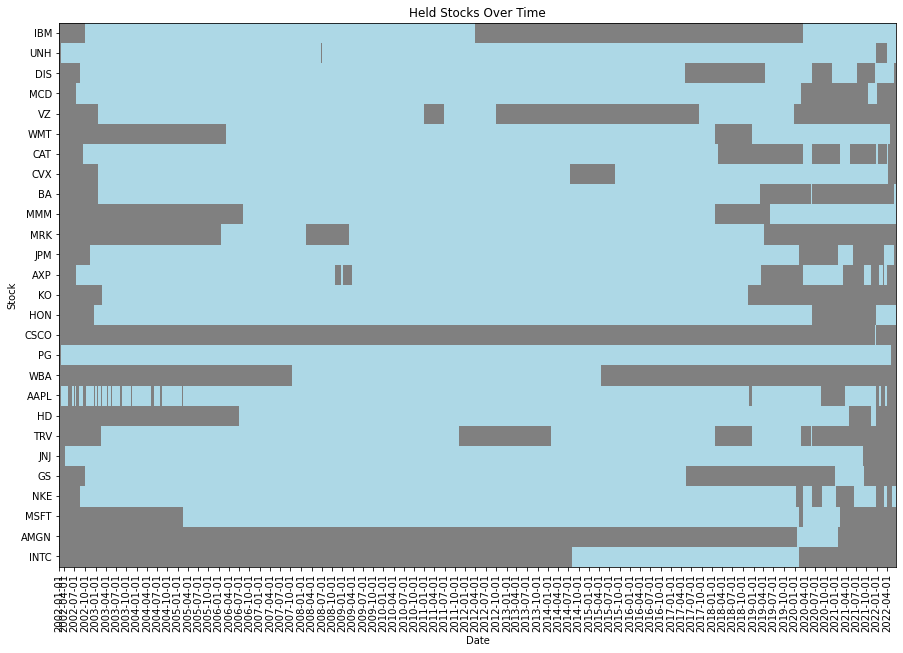

Period: 2002-02-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: []
Transaction Cost: 0.0

Period: 2002-03-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: []
Transaction Cost: 0.0

Period: 2002-04-01 00:00:00
Buy Stocks: ['MMM', 'UNH']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'UNH']
Transaction Cost: 0.00686

Period: 2002-05-01 00:00:00
Buy Stocks: ['AAPL']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'UNH', 'AAPL']
Transaction Cost: 0.00343

Period: 2002-06-01 00:00:00
Buy Stocks: ['CVX']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'UNH', 'AAPL', 'CVX']
Transaction Cost: 0.00343

Period: 2002-07-01 00:00:00
Buy Stocks: ['AMGN', 'BA']
Sold Stocks: ['AAPL']
Currently Held Stocks: ['MMM', 'UNH', 'CVX', 'AMGN', 'BA']
Transaction Cost: 0.01029

Period: 2002-08-01 00:00:00
Buy Stocks: ['CAT', 'DIS', 'IBM', 'WBA', 'WMT']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'UNH', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WBA', 'WMT']
Transaction Cost:

Period: 2005-09-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM', 'PG', 'HD', 'MCD', 'NKE', 'AXP', 'GS', 'JNJ', 'MSFT', 'AAPL', 'KO', 'UNH']
Transaction Cost: 0.0

Period: 2005-10-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM', 'PG', 'HD', 'MCD', 'NKE', 'AXP', 'GS', 'JNJ', 'MSFT', 'AAPL', 'KO', 'UNH']
Transaction Cost: 0.0

Period: 2005-11-01 00:00:00
Buy Stocks: ['INTC', 'MRK']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM', 'PG', 'HD', 'MCD', 'NKE', 'AXP', 'GS', 'JNJ', 'MSFT', 'AAPL', 'KO', 'UNH', 'INTC', 'MRK']
Transaction Cost: 0.00686

Period: 2005-12-01 00:00:00
Buy Stocks: ['VZ']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM'

Period: 2008-04-01 00:00:00
Buy Stocks: ['UNH']
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'AAPL', 'KO', 'MRK', 'VZ', 'INTC', 'WBA', 'GS', 'MSFT', 'UNH']
Transaction Cost: 0.00343

Period: 2008-05-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'AAPL', 'KO', 'MRK', 'VZ', 'INTC', 'WBA', 'GS', 'MSFT', 'UNH']
Transaction Cost: 0.0

Period: 2008-06-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'IBM', 'WMT', 'TRV', 'CSCO', 'HON', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'AAPL', 'KO', 'MRK', 'VZ', 'INTC', 'WBA', 'GS', 'MSFT', 'UNH']
Transaction Cost: 0.0

Period: 2008-07-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'AMGN', 'BA', 'CAT', 'DIS', 'I

Period: 2012-05-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'BA', 'CAT', 'DIS', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'KO', 'INTC', 'UNH', 'HON', 'HD', 'WBA', 'MRK', 'VZ']
Transaction Cost: 0.0

Period: 2012-06-01 00:00:00
Buy Stocks: []
Sold Stocks: ['UNH']
Currently Held Stocks: ['MMM', 'CVX', 'BA', 'CAT', 'DIS', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'KO', 'INTC', 'HON', 'HD', 'WBA', 'MRK', 'VZ']
Transaction Cost: 0.00343

Period: 2012-07-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'BA', 'CAT', 'DIS', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'KO', 'INTC', 'HON', 'HD', 'WBA', 'MRK', 'VZ']
Transaction Cost: 0.0

Period: 2012-08-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'CVX', 'BA', 'CAT', 'DIS', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'JNJ', 'KO', 'INTC', 'HON', 'HD', 'WBA', 'MRK', 'VZ']
Transaction Cost: 0.0

Period: 2012

Period: 2015-06-01 00:00:00
Buy Stocks: []
Sold Stocks: ['VZ']
Currently Held Stocks: ['MMM', 'BA', 'DIS', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'HON', 'HD', 'MRK', 'GS', 'TRV', 'KO', 'JNJ', 'UNH', 'MSFT']
Transaction Cost: 0.00343

Period: 2015-07-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['MMM', 'BA', 'DIS', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'HON', 'HD', 'MRK', 'GS', 'TRV', 'KO', 'JNJ', 'UNH', 'MSFT']
Transaction Cost: 0.0

Period: 2015-08-01 00:00:00
Buy Stocks: []
Sold Stocks: ['DIS']
Currently Held Stocks: ['MMM', 'BA', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'HON', 'HD', 'MRK', 'GS', 'TRV', 'KO', 'JNJ', 'UNH', 'MSFT']
Transaction Cost: 0.00343

Period: 2015-09-01 00:00:00
Buy Stocks: []
Sold Stocks: ['GS']
Currently Held Stocks: ['MMM', 'BA', 'WMT', 'CSCO', 'JPM', 'PG', 'MCD', 'NKE', 'AXP', 'HON', 'HD', 'MRK', 'TRV', 'KO', 'JNJ', 'UNH', 'MSFT']
Transaction Cost: 0.00343

Period: 2015-10-01 00:00:00
Buy Stocks: ['CVX', 'VZ

Period: 2018-10-01 00:00:00
Buy Stocks: []
Sold Stocks: ['JPM']
Currently Held Stocks: ['WMT', 'CSCO', 'PG', 'MCD', 'AXP', 'HD', 'MRK', 'JNJ', 'UNH', 'CVX', 'IBM', 'AAPL', 'DIS', 'MSFT', 'VZ', 'KO', 'CAT', 'NKE', 'TRV', 'WBA']
Transaction Cost: 0.00343

Period: 2018-11-01 00:00:00
Buy Stocks: []
Sold Stocks: ['WBA']
Currently Held Stocks: ['WMT', 'CSCO', 'PG', 'MCD', 'AXP', 'HD', 'MRK', 'JNJ', 'UNH', 'CVX', 'IBM', 'AAPL', 'DIS', 'MSFT', 'VZ', 'KO', 'CAT', 'NKE', 'TRV']
Transaction Cost: 0.00343

Period: 2018-12-01 00:00:00
Buy Stocks: ['AMGN']
Sold Stocks: ['MCD', 'UNH', 'VZ']
Currently Held Stocks: ['WMT', 'CSCO', 'PG', 'AXP', 'HD', 'MRK', 'JNJ', 'CVX', 'IBM', 'AAPL', 'DIS', 'MSFT', 'KO', 'CAT', 'NKE', 'TRV', 'AMGN']
Transaction Cost: 0.01372

Period: 2019-01-01 00:00:00
Buy Stocks: ['GS', 'HON', 'UNH']
Sold Stocks: []
Currently Held Stocks: ['WMT', 'CSCO', 'PG', 'AXP', 'HD', 'MRK', 'JNJ', 'CVX', 'IBM', 'AAPL', 'DIS', 'MSFT', 'KO', 'CAT', 'NKE', 'TRV', 'AMGN', 'GS', 'HON', 'UNH']
Tran

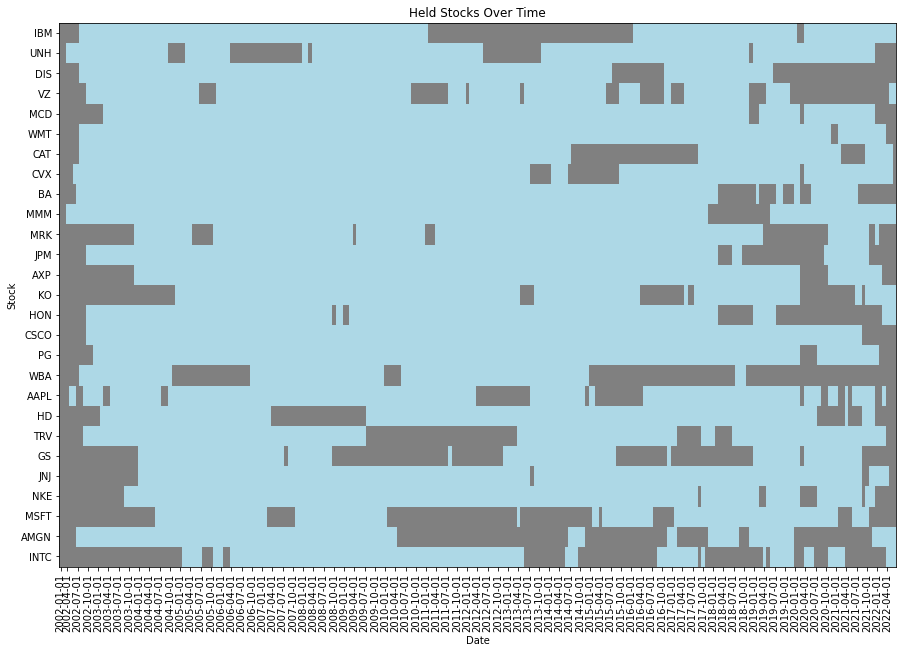

Period: 2002-01-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: []
Transaction Cost: 0.0

Period: 2002-04-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: []
Transaction Cost: 0.0

Period: 2002-07-01 00:00:00
Buy Stocks: ['AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DIS', 'GS', 'IBM', 'JNJ', 'MCD', 'NKE', 'UNH']
Sold Stocks: []
Currently Held Stocks: ['AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DIS', 'GS', 'IBM', 'JNJ', 'MCD', 'NKE', 'UNH']
Transaction Cost: 0.04459

Period: 2002-10-01 00:00:00
Buy Stocks: ['MMM', 'JPM', 'MRK', 'TRV', 'VZ']
Sold Stocks: ['MCD']
Currently Held Stocks: ['AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DIS', 'GS', 'IBM', 'JNJ', 'NKE', 'UNH', 'MMM', 'JPM', 'MRK', 'TRV', 'VZ']
Transaction Cost: 0.020579999999999998

Period: 2003-01-01 00:00:00
Buy Stocks: ['AXP', 'HON', 'MCD', 'WBA']
Sold Stocks: []
Currently Held Stocks: ['AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DIS', 'GS', 'IBM', 'JNJ', 'NKE', 'UNH', 'MMM', 'JPM', 'MRK'

Period: 2013-10-01 00:00:00
Buy Stocks: []
Sold Stocks: ['BA', 'CVX']
Currently Held Stocks: ['GS', 'NKE', 'MMM', 'TRV', 'VZ', 'AXP', 'MCD', 'WMT', 'HD', 'PG', 'AAPL', 'MSFT', 'HON', 'JNJ', 'JPM', 'DIS', 'KO', 'CSCO', 'MRK', 'UNH', 'WBA', 'AMGN', 'CAT', 'INTC']
Transaction Cost: 0.00686

Period: 2014-01-01 00:00:00
Buy Stocks: ['BA']
Sold Stocks: ['CSCO']
Currently Held Stocks: ['GS', 'NKE', 'MMM', 'TRV', 'VZ', 'AXP', 'MCD', 'WMT', 'HD', 'PG', 'AAPL', 'MSFT', 'HON', 'JNJ', 'JPM', 'DIS', 'KO', 'MRK', 'UNH', 'WBA', 'AMGN', 'CAT', 'INTC', 'BA']
Transaction Cost: 0.00686

Period: 2014-04-01 00:00:00
Buy Stocks: []
Sold Stocks: ['MSFT']
Currently Held Stocks: ['GS', 'NKE', 'MMM', 'TRV', 'VZ', 'AXP', 'MCD', 'WMT', 'HD', 'PG', 'AAPL', 'HON', 'JNJ', 'JPM', 'DIS', 'KO', 'MRK', 'UNH', 'WBA', 'AMGN', 'CAT', 'INTC', 'BA']
Transaction Cost: 0.00343

Period: 2014-07-01 00:00:00
Buy Stocks: []
Sold Stocks: []
Currently Held Stocks: ['GS', 'NKE', 'MMM', 'TRV', 'VZ', 'AXP', 'MCD', 'WMT', 'HD', 'PG', 'A

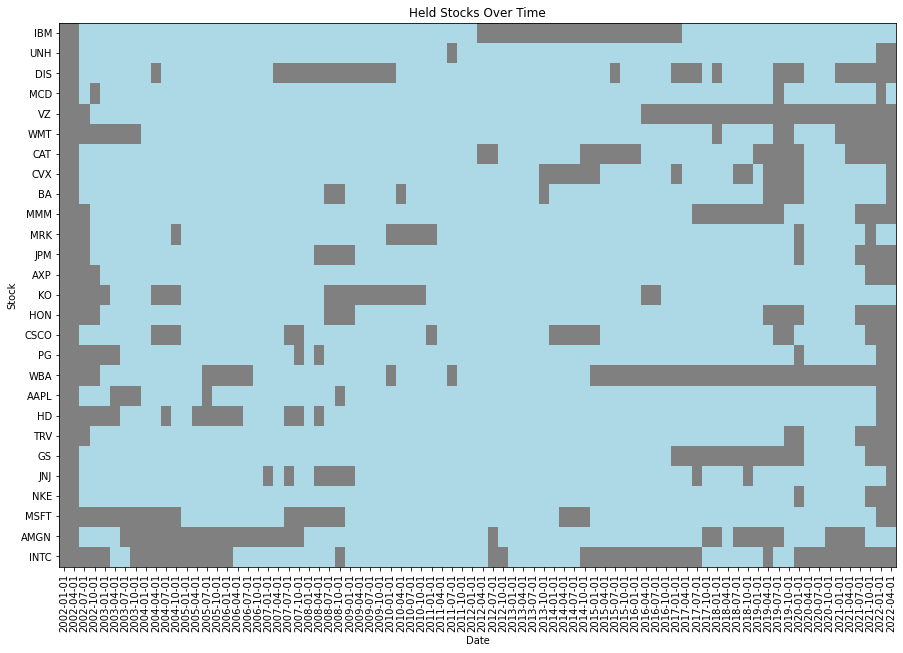

In [38]:
# Set pandas display option
pd.options.display.float_format = "{:,.5f}".format

# Calculate weekly returns
weekly_returns, held_stocks_over_time = calculate_returns(df_all, df_combined, shift=5, frequency='W')
# Set 'Date' as index for weekly returns
weekly_returns = weekly_returns.set_index('Date')
visualize_held_stocks(held_stocks_over_time)


# Calculate monthly returns
monthly_returns, held_stocks_over_time = calculate_returns(df_all, df_combined, shift=20, frequency='M')
# Set 'Date' as index for monthly returns
monthly_returns = monthly_returns.set_index('Date')
visualize_held_stocks(held_stocks_over_time)


# Calculate quarterly returns
quarterly_returns, held_stocks_over_time = calculate_returns(df_all, df_combined, shift=90, frequency='Q')
# Set 'Date' as index for quarterly returns
quarterly_returns = quarterly_returns.set_index('Date')
visualize_held_stocks(held_stocks_over_time)


## Performance Metrics

In [39]:
# Sort the 'Return' column in descending order and get the 20 highest values
top_20_returns = weekly_returns.nlargest(20, 'Return')

# Print the top 20 returns
print(top_20_returns['Return'])

Date
2020-03-24   0.11975
2008-10-28   0.10140
2020-03-13   0.09645
2008-11-13   0.07537
2009-03-10   0.06954
2008-11-21   0.06114
2008-09-30   0.06015
2020-03-26   0.05633
2020-03-04   0.05267
2020-03-17   0.05131
2020-03-10   0.05033
2008-12-16   0.04928
2018-12-26   0.04903
2009-01-21   0.04807
2002-07-24   0.04775
2011-08-09   0.04557
2002-10-11   0.04331
2002-10-15   0.04244
2008-12-05   0.04230
2009-04-09   0.04187
Name: Return, dtype: float64


In [40]:
result_list = [weekly_returns, monthly_returns, quarterly_returns]

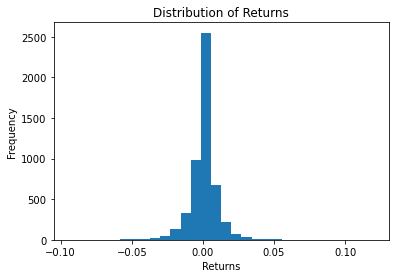

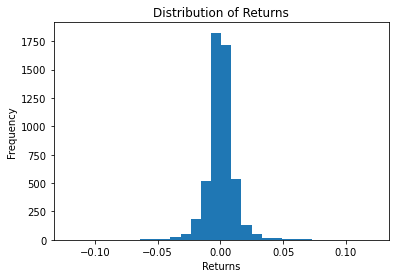

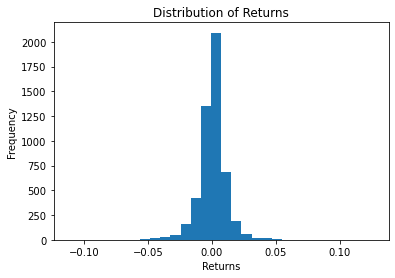

In [41]:
for res in result_list:

    # Calculate the distribution of returns
    returns_distribution = res['Net Return']

    # Plot a histogram of the returns distribution
    plt.hist(returns_distribution, bins=30)
    plt.xlabel('Returns')
    plt.ylabel('Frequency',)
    plt.title('Distribution of Returns')
    plt.show()

   



In [44]:


# Create an empty DataFrame to store the results
performance_metrics = pd.DataFrame(index=['Net Cumulative Return','Total Transaction Cost', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Maximum Drawdown',
                                          'Mean Return', 'Std Return', 'Skewness', 'Kurtosis', 
                                          'p-value', 't-statistic'])

# Define the frequencies you want to loop through
frequencies = {'Weekly': weekly_returns, 'Monthly': monthly_returns, 'Quarterly': quarterly_returns}

risk_free_rate = 0.00

for frequency, returns in frequencies.items():
    returns_distribution = returns['Net Return']
    trx_sum = returns['trx cost'].cumsum()
    annualized_return = (returns['Cum Return'].iloc[-1]) ** (252 / len(returns)) - 1
    annualized_volatility = np.std(returns_distribution) * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    cum_returns = returns['Cum Return']
    cum_max = returns['Cum Return'].cummax()
    drawdown = (cum_max - cum_returns) / cum_max
    max_drawdown = drawdown.max()

    mean_return = returns_distribution.mean()
    std_return = returns_distribution.std()
    skewness = returns_distribution.skew()
    kurtosis = returns_distribution.kurtosis()
    cum_return = cum_returns.iloc[-1]

    # Perform t-test
    t_statistic, p_value = stats.ttest_1samp(cum_returns, 0)

    # Add the results to the performance_metrics DataFrame
    performance_metrics[frequency] = pd.Series({
        'Net Cumulative Return': round(cum_return, 4),
        'Total Transaction Cost': trx_sum.iloc[-1],
        'Annualized Return': round(annualized_return, 4),
        'Annualized Volatility': round(annualized_volatility, 4),
        'Sharpe Ratio': round(sharpe_ratio, 4),
        'Maximum Drawdown': round(max_drawdown, 4),
        'Mean Return': round(mean_return, 4),
        'Std Return': round(std_return, 4),
        'Skewness': round(skewness, 4),
        'Kurtosis': round(kurtosis, 4),
        'p-value': round(p_value, 4),
        't-statistic': round(t_statistic, 4),
        
    })

# Print the performance_metrics DataFrame
performance_metrics

,Weekly,Monthly,Quarterly
Net Cumulative Return,9.00590,6.43280,7.74720
Total Transaction Cost,0.56252,0.85407,0.67571
Annualized Return,0.11420,0.09590,0.10600
Annualized Volatility,0.16140,0.18180,0.18540
Sharpe Ratio,0.70760,0.52770,0.57170
Maximum Drawdown,0.34210,0.43490,0.49800
Mean Return,0.00050,0.00040,0.00050
Std Return,0.01020,0.01150,0.01170
Skewness,0.34330,0.20790,0.13310
Kurtosis,15.27580,13.98190,14.21540


In [45]:
df_comb_pct = df_combined.pct_change()
df_comb_pct['mean_d'] = df_comb_pct.mean(axis = 1)
# Calculate cumulative return
df_comb_pct['cumulative_return'] = (1 + df_comb_pct['mean_d']).cumprod()

In [46]:
transaction_cost = 0.00343


# Create an empty DataFrame to store the results
performance_metrics = pd.DataFrame(index=['Net Cumulative Return','Total Transaction Cost', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Maximum Drawdown',
                                          'Mean Return', 'Std Return', 'Skewness', 'Kurtosis', 
                                          'p-value', 't-statistic'])

# Define the frequencies you want to loop through
frequencies = {'Weekly': weekly_returns, 'Monthly': monthly_returns, 'Quarterly': quarterly_returns}

risk_free_rate = 0.00

for frequency, returns in frequencies.items():
    returns_distribution = returns['Net Return']
    trx_sum = returns['trx cost'].cumsum()
    annualized_return = (returns['Cum Return'].iloc[-1]) ** (252 / len(returns)) - 1
    annualized_volatility = np.std(returns_distribution) * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    cum_returns = returns['Cum Return']
    cum_max = returns['Cum Return'].cummax()
    drawdown = (cum_max - cum_returns) / cum_max
    max_drawdown = drawdown.max()

    mean_return = returns_distribution.mean()
    std_return = returns_distribution.std()
    skewness = returns_distribution.skew()
    kurtosis = returns_distribution.kurtosis()
    cum_return = cum_returns.iloc[-1]

    # Perform t-test
    t_statistic, p_value = stats.ttest_1samp(cum_returns, 0)

    # Add the results to the performance_metrics DataFrame
    performance_metrics[frequency] = pd.Series({
        'Net Cumulative Return': round(cum_return, 4),
        'Total Transaction Cost': trx_sum.iloc[-1],
        'Annualized Return': round(annualized_return, 4),
        'Annualized Volatility': round(annualized_volatility, 4),
        'Sharpe Ratio': round(sharpe_ratio, 4),
        'Maximum Drawdown': round(max_drawdown, 4),
        'Mean Return': round(mean_return, 4),
        'Std Return': round(std_return, 4),
        'Skewness': round(skewness, 4),
        'Kurtosis': round(kurtosis, 4),
        'p-value': round(p_value, 4),
        't-statistic': round(t_statistic, 4),
        
    })
    
    
# Calculate mean return
mean_return_comb = df_comb_pct['mean_d'].mean()

# Calculate standard deviation of returns
std_return_comb = df_comb_pct['mean_d'].std()

# Calculate skewness of returns
skewness_comb = df_comb_pct['mean_d'].skew()

# Calculate kurtosis of returns
kurtosis_comb = df_comb_pct['mean_d'].kurtosis()

# Calculate cumulative return
cumulative_return_comb = df_comb_pct['cumulative_return'].iloc[-1]

# Calculate annualized return
annualized_return_comb = (cumulative_return_comb) ** (252 / len(df_comb_pct)) - 1

# Calculate annualized volatility
annualized_volatility_comb = np.std(df_comb_pct['mean_d']) * np.sqrt(252)

# Calculate Sharpe ratio (assuming risk-free rate of 0)
risk_free_rate_comb = 0
sharpe_ratio_comb = (annualized_return_comb - risk_free_rate_comb) / annualized_volatility_comb

# Calculate maximum drawdown
cumulative_returns_comb = df_comb_pct['cumulative_return']
peak_comb = cumulative_returns_comb.cummax()
drawdown_comb = (cumulative_returns_comb - peak_comb) / peak_comb
max_drawdown_comb = abs(drawdown_comb.min())

# Perform t-test (excluding NaN values)
t_statistic_comb, p_value_comb = stats.ttest_1samp(df_comb_pct['mean_d'].dropna(), 0)

  # Replace with your variable transaction cost
total_transaction_cost = transaction_cost * 27  # Assuming 27 stocks

# Create an empty DataFrame to store the results
performance_metrics_comb = pd.DataFrame(index=['Net Cumulative Return', 'Total Transaction Cost', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Maximum Drawdown',
                                          'Mean Return', 'Std Return', 'Skewness', 'Kurtosis', 
                                          'p-value', 't-statistic'])

# Add the calculated metrics to the performance_metrics_comb DataFrame
performance_metrics_comb['Equal Weighted'] = pd.Series({
    'Net Cumulative Return': round(cumulative_return_comb, 4),
    'Total Transaction Cost': round(total_transaction_cost, 4),
    'Annualized Return': round(annualized_return_comb, 4),
    'Annualized Volatility': round(annualized_volatility_comb, 4),
    'Sharpe Ratio': round(sharpe_ratio_comb, 4),
    'Maximum Drawdown': round(max_drawdown_comb, 4),
    'Mean Return': round(mean_return_comb, 4),
    'Std Return': round(std_return_comb, 4),
    'Skewness': round(skewness_comb, 4),
    'Kurtosis': round(kurtosis_comb, 4),
    'p-value': round(p_value_comb, 4),
    't-statistic': round(t_statistic_comb, 4),
    
})


# Concatenate the performance_metrics and performance_metrics_comb DataFrames
combined_metrics = pd.DataFrame()
combined_metrics = pd.concat([performance_metrics, performance_metrics_comb], axis=1)

# Print the combined_metrics DataFrame
combined_metrics

,Weekly,Monthly,Quarterly,Equal Weighted
Net Cumulative Return,9.00590,6.43280,7.74720,6.78300
Total Transaction Cost,0.56252,0.85407,0.67571,0.09260
Annualized Return,0.11420,0.09590,0.10600,0.09880
Annualized Volatility,0.16140,0.18180,0.18540,0.18910
Sharpe Ratio,0.70760,0.52770,0.57170,0.52230
Maximum Drawdown,0.34210,0.43490,0.49800,0.47050
Mean Return,0.00050,0.00040,0.00050,0.00040
Std Return,0.01020,0.01150,0.01170,0.01190
Skewness,0.34330,0.20790,0.13310,0.12650
Kurtosis,15.27580,13.98190,14.21540,13.36230


In [56]:
## combined_metrics.to_excel('Combined Metrics.xlsx')

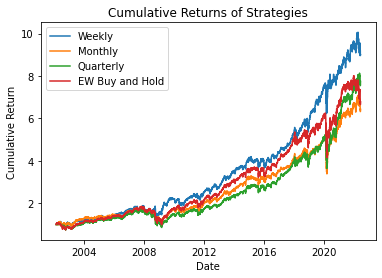

In [47]:
# Plot the cumulative returns
plt.plot(weekly_returns['Cum Return'], label='Weekly')
plt.plot(monthly_returns['Cum Return'], label='Monthly')
plt.plot(quarterly_returns['Cum Return'], label='Quarterly')
plt.plot(df_comb_pct['cumulative_return'], label='EW Buy and Hold')

# Set the plot title and labels
plt.title('Cumulative Returns of Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

# Add a legend
plt.legend()

# Display the plot
plt.show()

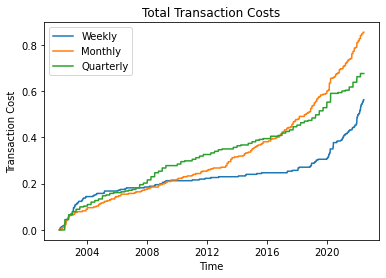

In [49]:
# Calculate the cumulative sum of 'trx cost' column for each DataFrame
weekly_cumulative_sum = weekly_returns['trx cost'].cumsum()
monthly_cumulative_sum = monthly_returns['trx cost'].cumsum()
quarterly_cumulative_sum = quarterly_returns['trx cost'].cumsum()

# Create the plot
plt.plot(weekly_cumulative_sum, label='Weekly')
plt.plot(monthly_cumulative_sum, label='Monthly')
plt.plot(quarterly_cumulative_sum, label='Quarterly')

# Set plot title and labels
plt.title("Total Transaction Costs")
plt.xlabel("Time")
plt.ylabel("Transaction Cost")

# Add legend
plt.legend()

# Display the plot
plt.show()
